In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math

In [25]:
# connect to google drive
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/MyDrive/Capstone/Project_1")  
    in_colab = True
except:
    pass

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [162]:
# Load Data

gdp_df = pd.read_excel("Data/GDP_quarterly_data.xlsx")
gdp_df = gdp_df.drop(['Unnamed: 0'], axis =1)

cpi_df = pd.read_excel("Data/CPI_Monthly_Change.xlsx")
cpi_df = cpi_df.drop(['Unnamed: 0'], axis =1)

cpi_df = cpi_df[1:].reset_index(drop=True) # drop first row - doesn't have a previous month to calculate change

In [163]:
gdp_df.head()

,Year,Gross domestic product,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,Gross private domestic investment,Fixed investment,Nonresidential,...,Services.1,Imports,Goods.2,Services.2,Government consumption expenditures and gross investment,Federal,National defense,Nondefense,State and local,CPI
0,1947Q2,-1.1,6.8,7.4,8.7,7.0,5.9,-27.3,-10.0,-6.1,...,38.3,7.9,9.4,3.4,-0.4,-3.3,-25.2,224.5,5.7,21.933333
1,1947Q3,-0.8,1.3,2.7,5.6,1.9,-0.8,-11.3,13.6,-7.2,...,-8.4,-38.2,-43.9,-14.8,-0.1,-5.0,11.2,-48.5,9.4,22.566667
2,1947Q4,6.4,0.1,1.5,28.6,-5.1,-2.1,102.9,37.2,11.6,...,-17.2,23.5,5.5,98.0,-3.2,-8.6,8.9,-58.5,6.4,23.166667
3,1948Q1,6.2,2.0,0.6,-2.0,1.3,4.3,47.8,13.4,25.3,...,-25.5,61.6,86.5,5.7,6.1,10.4,-4.5,113.2,-0.9,23.533333
4,1948Q2,6.8,4.7,3.7,2.7,4.0,6.4,27.1,-0.6,-12.7,...,-18.6,16.8,16.5,17.3,14.9,16.9,-8.7,200.7,11.4,23.933333


In [164]:
cpi_df.head()

,TimeStamp,CPI,Prev_CPI,Change
0,1913-Feb,9.8,9.8,0.0
1,1913-Mar,9.8,9.8,0.0
2,1913-Apr,9.8,9.8,0.0
3,1913-May,9.7,9.8,-0.1
4,1913-June,9.8,9.7,0.1


## Gross Domestic Product

### Evaluate Autocorrelation of Dependent Variable

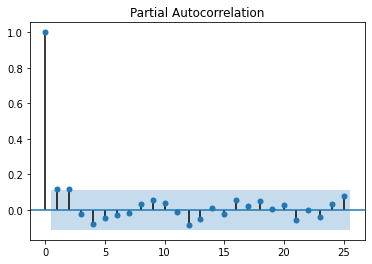

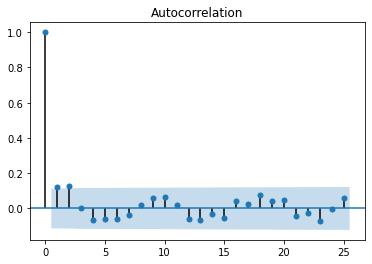

In [6]:
# https://vitalflux.com/autoregressive-ar-models-with-python-examples/
# https://www.youtube.com/watch?v=lPvIkGZjbZk

# Load AutoReg class from statsmodels.tsa.ar_model module
#
from statsmodels.tsa.ar_model import AutoReg

# find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(gdp_df['Gross domestic product'], lags=25)
acf = plot_acf(gdp_df['Gross domestic product'], lags=25)

In [165]:
# Specify size of training set

num_gdp_timepoints = len(gdp_df)
gdp_training_size = int(num_gdp_timepoints * 0.99)
gdp_training = gdp_df[:gdp_training_size]
gdp_testing = gdp_df[gdp_training_size:]

print(f"Total number of GDP Timepoints: {num_gdp_timepoints}")
print(f"Training Timepoints: {gdp_training_size}")
print(f"Testing Timepoints: {len(gdp_df) - gdp_training_size}")

# Predict 4 quarters in advance

Total number of GDP Timepoints: 303
Training Timepoints: 299
Testing Timepoints: 4


### Autoregressive Model

In [182]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html

gdp_ra_model = AutoReg(gdp_training['Gross domestic product'], lags=10).fit()

# P value for each "L.1, L.2 .." indicates whether corresponding lag statistically
# significant when predicting current data. For quarterly GDP Data, very few lags are 
# significant

print(gdp_ra_model.summary()) 

                              AutoReg Model Results                               
Dep. Variable:     Gross domestic product   No. Observations:                  299
Model:                        AutoReg(10)   Log Likelihood                -848.886
Method:                   Conditional MLE   S.D. of innovations              4.565
Date:                    Tue, 07 Feb 2023   AIC                              3.120
Time:                            03:31:38   BIC                              3.272
Sample:                                10   HQIC                             3.181
                                      299                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                      2.6320      0.589      4.469      0.000       1.478       3.786
Gross domestic product.L1      0.0906      0.059   

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [183]:
# make predictions

gdp_ra_preds = gdp_ra_model.predict(start = len(gdp_training), end = len(gdp_df) -1, dynamic = False)

In [184]:
# gdp_testing

### Moving Average Model

In [185]:
# https://www.kaggle.com/code/carlmcbrideellis/time-series-a-simple-moving-average-ma-model

from statsmodels.tsa.arima.model import ARIMA

gdp_ma_model = ARIMA(endog=gdp_training['Gross domestic product'], order=(0, 0, 10))

gdp_ma_results = gdp_ma_model.fit()
print(gdp_ma_results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Gross domestic product   No. Observations:                  299
Model:                    ARIMA(0, 0, 10)   Log Likelihood                -876.388
Date:                    Tue, 07 Feb 2023   AIC                           1776.777
Time:                            03:31:45   BIC                           1821.182
Sample:                                 0   HQIC                          1794.550
                                    - 299                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2031      0.399      8.027      0.000       2.421       3.985
ma.L1          0.0971      0.032      3.077      0.002       0.035       0.159
ma.L2          0.152

In [186]:
gdp_ma_preds = gdp_ma_results.predict(start = len(gdp_training), end = len(gdp_df) -1)

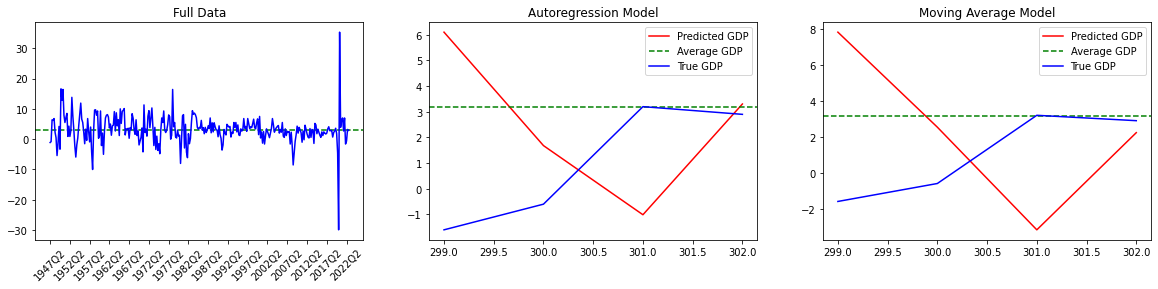

In [187]:
gdp_years = list(gdp_df['Year'])
testing_gdp_years = list(gdp_testing['Year'])

fig, ax = plt.subplots(1, 3, figsize = (20, 4))

# ax[0].plot(gdp_ra_preds, color='red', label = 'Predicted GDP')
ax[0].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--', label = 'Average GDP')
ax[0].plot(gdp_df['Year'], gdp_df['Gross domestic product'], color = 'blue', )
ax[0].set_xticks(gdp_years[::20])
ax[0].set_xticklabels(gdp_years[::20], rotation=45)
ax[0].set_title("Full Data")

ax[1].plot(gdp_ra_preds, color='red', label = 'Predicted GDP')
ax[1].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--',  label = 'Average GDP')
ax[1].plot(gdp_testing['Gross domestic product'], color = 'blue', label='True GDP')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[1].set_title("Autoregression Model")
ax[1].legend()

ax[2].plot(gdp_ma_preds, color='red', label = 'Predicted GDP')
ax[2].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--', label = 'Average GDP')
ax[2].plot(gdp_testing['Gross domestic product'], color = 'blue', label = 'True GDP')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[2].set_title("Moving Average Model")
ax[2].legend()

plt.show()

## Consumer Price Index

### Evaluate Autocorrelation of Dependent Variable

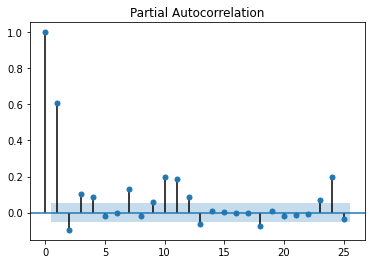

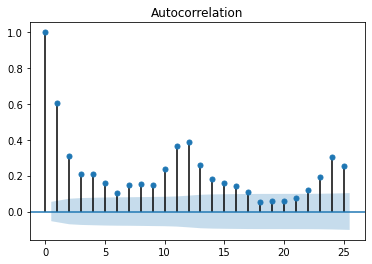

In [31]:
pacf = plot_pacf(cpi_df['Change'], lags=25)
acf = plot_acf(cpi_df['Change'], lags=25)

In [166]:
# specify size of training data

num_cpi_timepoints = len(cpi_df)
cpi_training_size = int(num_cpi_timepoints * 0.99)
cpi_training = cpi_df[:cpi_training_size]
cpi_testing = cpi_df[cpi_training_size:]

print(f"Total number of CPI Timepoints: {num_cpi_timepoints}")
print(f"Training Timepoints: {cpi_training_size}")
print(f"Testing Timepoints: {len(cpi_df) - cpi_training_size}")

# Predict up to 14 months in advance

Total number of CPI Timepoints: 1319
Training Timepoints: 1305
Testing Timepoints: 14


It should be noted that for this particular analysis the Consumer Price Index data did not satisfy the assumptions (stationarity) for Autoregressive Time Series Modeling, although we have modeled the data here out of interest.

In [145]:
# initialize model with specified number of lags
cpi_ra_model = AutoReg(cpi_training['Change'], lags=15).fit()

print(cpi_ra_model.summary()) 

                            AutoReg Model Results                             
Dep. Variable:                 Change   No. Observations:                 1305
Model:                    AutoReg(15)   Log Likelihood                -428.312
Method:               Conditional MLE   S.D. of innovations              0.337
Date:                Tue, 07 Feb 2023   AIC                             -2.147
Time:                        01:41:50   BIC                             -2.079
Sample:                            15   HQIC                            -2.122
                                 1305                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0328      0.013      2.562      0.010       0.008       0.058
Change.L1      0.6064      0.028     21.603      0.000       0.551       0.661
Change.L2     -0.1419      0.033     -4.331      0.0

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


In [146]:
# make predictions

cpi_ra_preds = cpi_ra_model.predict(start = len(cpi_training), end = len(cpi_df) -1, dynamic = False)

### Moving Average Model

In [147]:
from statsmodels.tsa.arima.model import ARIMA

cpi_ma_model = ARIMA(endog=cpi_training['Change'], order=(0, 0, 15))

cpi_ma_results = cpi_ma_model.fit()
print(cpi_ma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Change   No. Observations:                 1305
Model:                ARIMA(0, 0, 15)   Log Likelihood                -443.367
Date:                Tue, 07 Feb 2023   AIC                            920.733
Time:                        01:42:00   BIC                           1008.690
Sample:                             0   HQIC                           953.729
                               - 1305                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2103      0.031      6.788      0.000       0.150       0.271
ma.L1          0.6355      0.017     38.054      0.000       0.603       0.668
ma.L2          0.2844      0.019     14.859      0.0

In [148]:
# make predictions

cpi_ma_preds = cpi_ma_results.predict(start = len(cpi_training), end = len(cpi_df) -1)

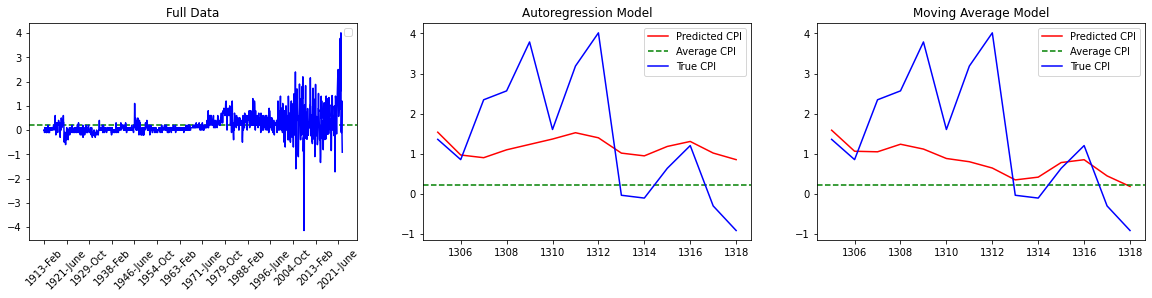

In [173]:
cpi_years = list(cpi_df['TimeStamp'])
# testing_gdp_years = list(gdp_testing['Year'])

fig, ax = plt.subplots(1, 3, figsize = (20, 4))

ax[0].axhline(cpi_df['Change'].mean(), color='green', linestyle='--')
ax[0].plot(cpi_df['TimeStamp'], cpi_df['Change'], color = 'blue')
ax[0].set_xticks(cpi_years[::100])
ax[0].set_xticklabels(cpi_years[::100], rotation=45)
ax[0].legend()
ax[0].set_title("Full Data")

ax[1].plot(cpi_ra_preds, color='red', label = 'Predicted CPI')
ax[1].axhline(cpi_df['Change'].mean(), color='green', linestyle='--', label = 'Average CPI')
ax[1].plot(cpi_testing['Change'], color = 'blue', label = 'True CPI')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[1].legend()
ax[1].set_title("Autoregression Model")

ax[2].plot(cpi_ma_preds, color='red', label = 'Predicted CPI')
ax[2].axhline(cpi_df['Change'].mean(), color='green', linestyle='--', label = 'Average CPI')
ax[2].plot(cpi_testing['Change'], color = 'blue', label='True CPI')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[2].set_title("Moving Average Model")
ax[2].legend()

plt.show()

## Old Code

In [49]:
# gdp_df_temp = gdp_df[['Year', 'Gross domestic product']]
# gdp_df_temp['Lag1'] = gdp_df['Gross domestic product'].shift(1) # GDP 1 quarter before
# gdp_df_temp['Lag2'] = gdp_df['Gross domestic product'].shift(2) # GDP 2 quarters before
# gdp_df_temp['Lag3'] = gdp_df['Gross domestic product'].shift(3) # GDP 3 quarters before
# gdp_df_temp['Spending on cars'] = 123
# gdp_df_temp['Unemployment Rate'] = 0.05
# gdp_df_temp['President Poltical Party'] = 'Republican'

In [50]:
# gdp_df_temp.head()

In [ ]:
# Gross Domomestic Product is Good - we want GDP to be roughly 2%
# if too high, can lead to inflation
# if negative, can lead to recession

In [ ]:
# For ML - we can only predict a single value (the GDP or CPI of a specific Quarter)
# If we want to get for additional quarters, we have to train a new model with our 
# target variable as the new quarter

# For time series, we can predict as far out (and for as many quarters) as we want
# But we only use time and previous GDP data for the models